<div class="markdown-google-sans">

## <strong>Импорт необходимых библиотек, модели для обучения, а также распаковка набора данных</strong>
</div>

In [1]:
from IPython.display import clear_output 
import cv2
# !pip3 install google-colab
# from google.colab.patches import cv2_imshow
clear_output()

In [2]:
# Скачивание репозитория с YOLOv5 и необходимых библиотек для работы модели
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt
clear_output()

In [3]:
# Создаём файл для собственной структуры датасета
!touch ./yolov5/data/custom.yaml

In [6]:
# Примерная структура датасета. в случае если называете директории по другому, измените их название
"""
train: ../price_tags/images/train/,
val:  ../price_tags/images/val/,
test: ../price_tags/images/test/,
# number of classes,
nc: 4,
# class names,
names: ["price_rub", "price_kop", "price_card_rub", "price_card_kop"]
"""

# Записываем в созданный ранее файл структуру датасете
my_file = open('/kaggle/working/yolov5/data/custom.yaml','w+')
my_file.write('train: ../price_tags/images/train/ \nval:  ../price_tags/images/val/ \ntest: ../price_tags/images/test/ \n# number of classes \nnc: 4 \n# class names \nnames: ["price_rub", "price_kop", "price_card_rub", "price_card_kop"]')

215

In [7]:
# Проверка записи в файл структуры. Если вывод пустой, повторно запустите предыдущую ячейку
my_file.readlines()

['train: ../price_tags/images/train/ \n',
 'val:  ../price_tags/images/val/ \n',
 'test: ../price_tags/images/test/ \n',
 '# number of classes \n',
 'nc: 4 \n',
 '# class names \n',
 'names: ["price_rub", "price_kop", "price_card_rub", "price_card_kop"]']

In [8]:
!pip install imageio
!pip install imutils
clear_output()

In [9]:
import random
from PIL import Image, ImageDraw
import numpy as np
from numpy import int64
import matplotlib.pyplot as plt
import os
import glob
from imageio import imread
import cv2
# from google.colab.patches import cv2_imshow
import imutils
import json

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import torch
from IPython.display import Image
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

<div class="markdown-google-sans">

## <strong>Предобработка датасета</strong>
</div>

In [10]:
# Функция для копирования файлов
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [11]:
# Создаём папки для хранения датасета на "внешнем" хранилище, чтобы можно было их изменять
!mkdir ./yolov5/price_tags
!mkdir ./yolov5/price_tags/images ./yolov5/price_tags/labels

In [12]:
originImgs = "../input/price-detection-for-yolov5/yolo5_tags/images/"
originLabls = "../input/price-detection-for-yolov5/yolo5_tags/labels/"

# Создаём пустые списки для хранения путей к изображениям и разметкам
images = []
annotations = []

# Копируем изображения из "внутреннего" датасета в ранее созданные папки
for fl in sorted(os.listdir(originImgs)):
    images.append(originImgs+fl)
move_files_to_folder(images, "./yolov5/price_tags/images/")    
for fl in sorted(os.listdir(originLabls)):
    annotations.append(originLabls+fl)
move_files_to_folder(annotations, "./yolov5/price_tags/labels/")  

In [13]:
# Проверка наличия файлов. Количество файлов должно совпадать
!ls ./yolov5/price_tags/labels/
print('-----------------')
!ls ./yolov5/price_tags/images/

'photo (1).txt'    'photo (110).txt'  'photo (122).txt'  'photo (137).txt'
'photo (10).txt'   'photo (111).txt'  'photo (123).txt'  'photo (138).txt'
'photo (100).txt'  'photo (112).txt'  'photo (124).txt'  'photo (139).txt'
'photo (101).txt'  'photo (113).txt'  'photo (125).txt'  'photo (14).txt'
'photo (102).txt'  'photo (114).txt'  'photo (126).txt'  'photo (140).txt'
'photo (103).txt'  'photo (115).txt'  'photo (127).txt'  'photo (142).txt'
'photo (104).txt'  'photo (116).txt'  'photo (128).txt'  'photo (143).txt'
'photo (105).txt'  'photo (117).txt'  'photo (129).txt'  'photo (144).txt'
'photo (106).txt'  'photo (118).txt'  'photo (13).txt'	 'photo (145).txt'
'photo (107).txt'  'photo (119).txt'  'photo (130).txt'  'photo (147).txt'
'photo (108).txt'  'photo (12).txt'   'photo (131).txt'  'photo (148).txt'
'photo (109).txt'  'photo (120).txt'  'photo (133).txt'
'photo (11).txt'   'photo (121).txt'  'photo (136).txt'
-----------------
'photo (1).jpg'    'photo (110).jpg'  'photo (1

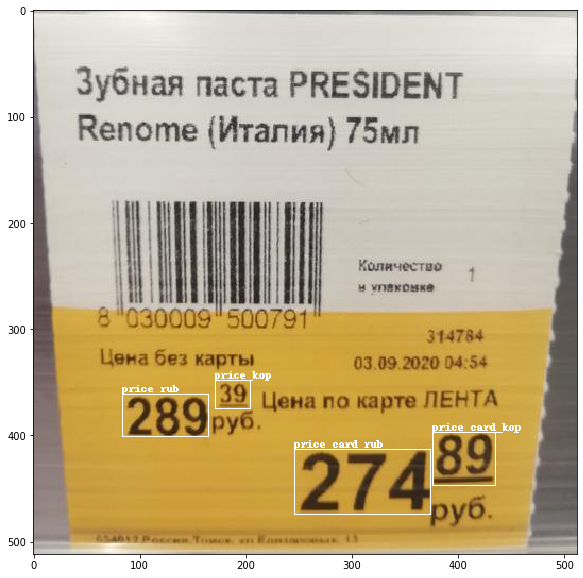

In [14]:
# Определение id классов объектов
class_name_to_id_mapping = {"price_rub": 0,
                            "price_kop": 1,
                            "price_card_rub": 2,
                            "price_card_kop": 3}

# Установка сида рандомной генерации
random.seed(0)

# Определяем словарь с id классов
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Функция для демонстрации разметки
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    
    # Получаем размер изображения
    w, h = image.size
    
    # Выводим исходное изображение
    plotted_image = ImageDraw.Draw(image)

    # Конвертируем координаты для показа
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    # Вывод разметки и классов объектов
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.figure(figsize = (30,10))
    plt.imshow(np.array(image), interpolation='nearest')
    plt.show()

# Выбираем случайный файл разметки
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# Получаем соответствующий файл с разметкой
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

# Загрузка изображения
image = Image.open(image_file)

# Показ разметки
plot_bounding_box(image, annotation_list)

In [15]:
# Заносим пути к файлам изображений и разметки
images = [os.path.join('./yolov5/price_tags/images', x) for x in os.listdir('./yolov5/price_tags/images')]
annotations = [os.path.join('./yolov5/price_tags/labels', x) for x in os.listdir('./yolov5/price_tags/labels') if x[-3:] == "txt"]

# Сортировка файлов
images.sort()
annotations.sort()

# Разделение датасета на обучающую, валидационную и тестовую выборки
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# Создаём папки для хранения выборок
!mkdir ./yolov5/price_tags/images/train/ ./yolov5/price_tags/images/val/ ./yolov5/price_tags/images/test/ ./yolov5/price_tags/labels/train/ ./yolov5/price_tags/labels/val/ ./yolov5/price_tags/labels/test/

# Функция для переноса файлов
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Перенос выборок в соответствующие папки
move_files_to_folder(train_images, './yolov5/price_tags/images/train/')
move_files_to_folder(val_images, './yolov5/price_tags/images/val/')
move_files_to_folder(test_images, './yolov5/price_tags/images/test/')
move_files_to_folder(train_annotations, './yolov5/price_tags/labels/train/')
move_files_to_folder(val_annotations, './yolov5/price_tags/labels/val/')
move_files_to_folder(test_annotations, './yolov5/price_tags/labels/test/')

In [16]:
# Проверяем содержание тестовой выборки
!ls ./yolov5/price_tags/labels/test/
print('-------------')
!ls ./yolov5/price_tags/images/test/

'photo (100).txt'  'photo (127).txt'  'photo (147).txt'
'photo (123).txt'  'photo (138).txt'
-------------
'photo (100).jpg'  'photo (127).jpg'  'photo (147).jpg'
'photo (123).jpg'  'photo (138).jpg'


<div class="markdown-google-sans">

## <strong>Обучение и тестирование модели</strong>
</div>

In [17]:
# Переходим в директорию yolov5
%cd ./yolov5

/kaggle/working/yolov5


In [18]:
# Запуск обучения с указанием параметров
# Измените параметры обучения так, чтобы добиться наилучших показателей

# Вы можете использовать различные модели, представленные в директории "/content/yolov5/models/"
# Информация об обучении разных моделей имеется в официальном репозитории: https://github.com/ultralytics/yolov5
# При выборе другой модели, не забудьте сменить веса для модели

#                img size  |  model config                               batch size|num of epochs |           dataset                   | weights for model               |   name of model
!python train.py --img 512 --cfg yolov5s.yaml --hyp hyp.scratch-med.yaml --batch 16 --epochs 100 --data ./data/custom.yaml --weights yolov5s.pt --workers 24 --name yolo_price_det

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=./data/custom.yaml, hyp=hyp.scratch-med.yaml, epochs=100, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_price_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://

In [19]:
# Запуск детектирования на тестовой выборке
!python detect.py --source ./price_tags/images/test/ --weights runs/train/yolo_price_det/weights/best.pt --conf 0.25 --name yolo_price_det

detect: weights=['runs/train/yolo_price_det/weights/best.pt'], source=./price_tags/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_price_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-198-g34c2187 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /kaggle/working/yolov5/price_tags/images/test/photo (100).jpg: 640x640 1 price_kop, 3 price_card_rubs, 2 price_card_kops, 6.9ms
image 2/5 /kaggle/working/yolov5/price_tags/images/test/photo (123).jpg: 640x640 1 price_rub, 3 price_card_rubs, 2 price_card_kops, 7.1ms
image 3/5 /kaggle/working/yolov5/p

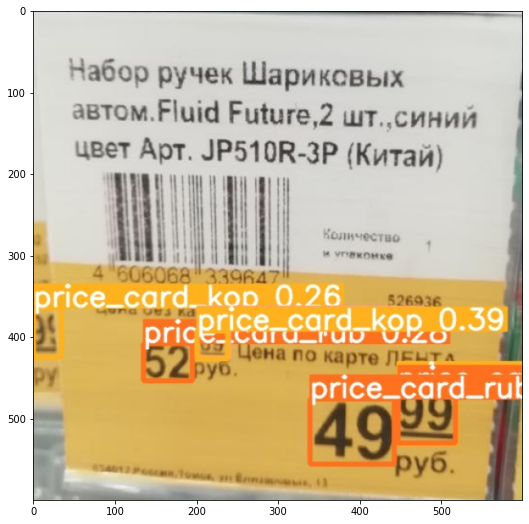

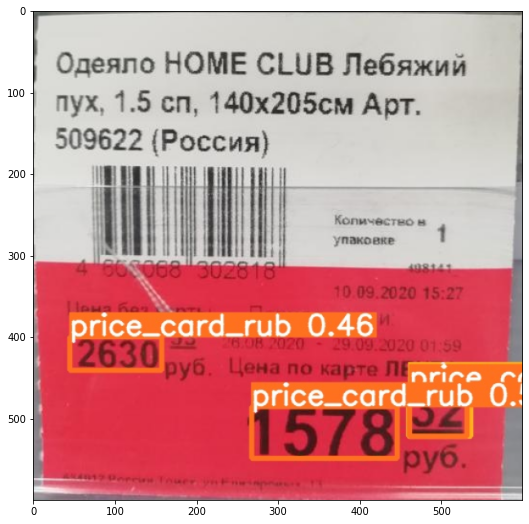

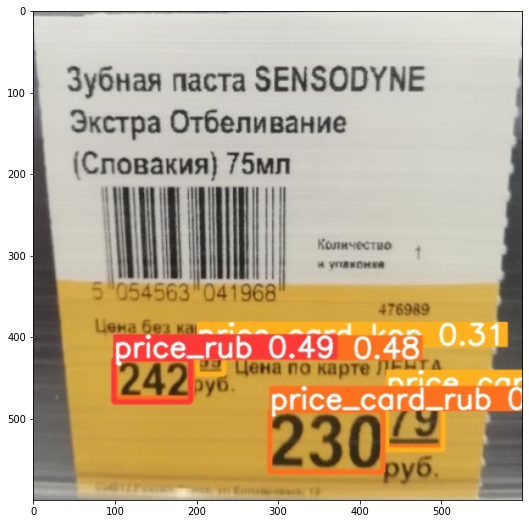

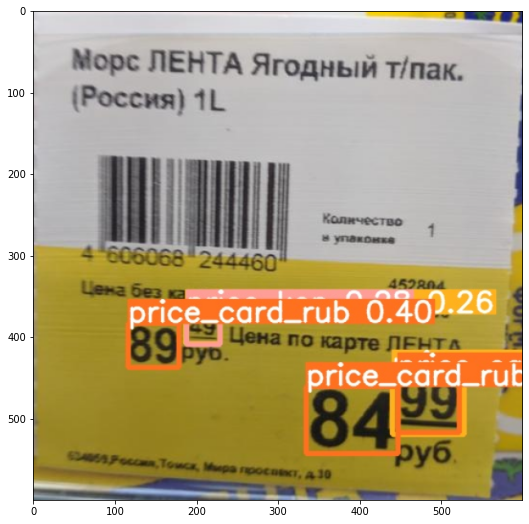

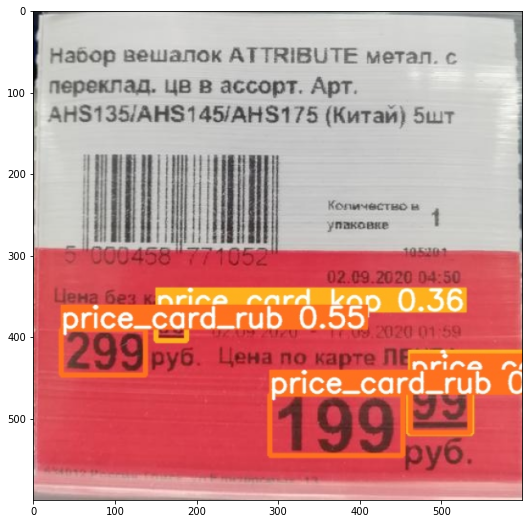

In [21]:
# Определяем путь к тестовой выборке
detections_dir = "./runs/detect/yolo_price_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

# Вывод изображения с результатами детектирования
# random_detection_image = Image.open(random.choice(detection_images))
# plt.figure(figsize = (30,10))
# plt.imshow(np.array(random_detection_image))
for fl in os.listdir(detections_dir):
  img = cv2.imread(detections_dir+fl)
  img = imutils.resize(img, width=600)
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img)
    
#   cv2_imshow(img)
  plt.figure(figsize=(9,9))
  plt.imshow(img)
  plt.show()

In [22]:
# Запуск тестирования обученной модели, для получения метрик
# Результаты метрики mAP50-95 для всех классов (all) являются результатами обучения модели на тестовой выборке
print('test results:')
!python val.py --weights ./runs/train/yolo_price_det/weights/best.pt --data custom.yaml --task test --name yolo_price_det_test

test results:
val: data=/kaggle/working/yolov5/data/custom.yaml, weights=['./runs/train/yolo_price_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_price_det_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-198-g34c2187 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /kaggle/working/yolov5/price_tags/labels/test... 5 images, 0 back
test: New cache created: /kaggle/working/yolov5/price_tags/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   
                   all          5         20      0.471      0.898      0.758       0.63
             price_rub          5          5      0.261      

<div class="markdown-google-sans">

## <strong>Расчёт точности на тестовом изображении</strong>
</div>

In [23]:
def move_files_to_folder(file_path, destination_folder):
        try:
            shutil.copy(file_path, destination_folder)
        except:
            print(f)
            assert False

In [24]:
# Определяем собственную модель
model = torch.hub.load('ultralytics/yolov5', 'custom', path="./runs/train/yolo_price_det/weights/best.pt")

# Копируем тестовое изображение на "внешнее" хранилище
move_files_to_folder("/kaggle/input/price-detection-for-yolov5/yolo5_tags/cropTest.jpg", "/kaggle/working/yolov5/price_tags/cropTest.jpg")

# Определяем путь к тестовому изображению, выданному Вам
img = "./price_tags/cropTest.jpg"

# Получаем результаты детектирования
results = model(img)

# Вывод результатов
results.print() 
results.pandas().xyxy[0]

# Вырезаем найденные сегменты, для дальнейшего распознования
crops = results.crop(save=True) 

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.8s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-7-31 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 512x512 1 price_kop, 3 price_card_rubs, 2 price_card_kops
Speed: 9.9ms pre-process, 12.1ms inference, 1.9ms NMS per image at shape (1, 3, 640, 640)
Saved 1 image to runs/detect/exp
Saved results to runs/detect/exp



In [25]:
ls runs/detect/exp/crops/

price_card_kop/  price_card_rub/  price_kop/


Если были созданы директории не всех сегментов, значит распознование областей цен выпонено не качествено, и дальнейший код для распознования текста может не выполнятся. Для решения данной проблемы необходимо либо переобучить модель и получить более высокие показатели детектирования, либо разделить блок с распознованием текста на разные блоки под каждый сегмент

In [26]:
# Установка и импорт API EasyOCR для разпознавания текста
!pip install easyocr
import easyocr
clear_output()

In [27]:
# Определение EasyOCR и доступных языков
reader = easyocr.Reader(['ru','en'])

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [28]:
try:
    img_price_rub = cv2.imread('./runs/detect/exp/crops/price_rub/cropTest.jpg')
    result = reader.readtext(img_price_rub,allowlist='1234567890')
    price_rub = ""
    for box in result:
        price_rub = price_rub + "" + box[1]
    print(price_rub)
except:
    price_rub = '0'
    print(price_rub)
    
try:
    img_price_kop = cv2.imread('./runs/detect/exp/crops/price_kop/cropTest.jpg')
    result = reader.readtext(img_price_kop, allowlist='1234567890')
    price_kop = ""
    for box in result:
        price_kop = price_kop + "" + box[1]
    print(price_kop)
except:
    price_rub = '0'
    print(price_kop)
    
try:
    img_price_card_rub = cv2.imread('./runs/detect/exp/crops/price_card_rub/cropTest.jpg')
    result = reader.readtext(img_price_card_rub, allowlist='1234567890')
    price_card_rub = ""
    for box in result:
        price_card_rub = price_card_rub + "" + box[1]
    print(price_card_rub)
except:
    price_rub = '0'
    print(price_card_rub)
    
try:
    img_price_card_kop = cv2.imread('./runs/detect/exp/crops/price_card_kop/cropTest.jpg')
    result = reader.readtext(img_price_card_kop, allowlist='1234567890')
    price_card_kop = ""
    for box in result:
        price_card_kop = price_card_kop + "" + box[1]
    print(price_card_kop)
except:
    price_rub = '0'
    print(price_card_kop)
    
price = price_rub+'.'+price_kop
price_card = price_card_rub+'.'+price_card_kop

# Вывод распознанных цен
print('price:', price)
print('price_card:', price_card)

0
39
526
99
price: 0.39
price_card: 526.99


In [29]:
def MAPE(true, pred): 
    res = abs(((true-pred)/pred)*100)
    return res

# Замените на свои ФИО
name = 'Иванов Иван Иванович1'
# Замените на полученную точность согласно метрики mAP50-95 для всех классов (all)
acc = '0.60'
print(name)
print('mAP50-95:', acc)
print('MAPE no card:', MAPE(526.39, float(price)))
print('MAPE card:', MAPE(499.99, float(price_card)))

Иванов Иван Иванович1
mAP50-95: 0.60
MAPE no card: 134871.79487179487
MAPE card: 5.123436877360102
